# Adult Income Classification Project

Le projet vise à analyser le jeu de données Adult Income afin d’identifier les différents facteurs qui influencent le niveau de revenu d'une personne et de construire un modèle capable de prédire si une personne gagne plus ou moins de 50 000 dollars par an. 

Le dataset, disponible dans plusieurs versions (UCI, OpenML, variantes nettoyées ou simplifiées), est ici utilisé dans sa version OpenML, qui offre un format homogène et des variables à la fois numériques et catégorielles. Notre problème sera approché sous la forme d'une classification binaire (+ ou - de 50k$/an de revenus) car le dataset ne contient pas la valeur exacte du revenu, qu'une catégorie.

Ce notebook sera articulé en trois grandes parties :

1. **Exploration des données (EDA) et analyses non supervisées**
2. **Préprocessing des données et séparation des jeux d'apprentissage/test**
3. **Modélisation supervisée (baseline vs ensembles) et comparaison des performances**

Chaque section inclut des explications détaillées pour assurer la reproductibilité de l'analyse.


Avant de commencer, voici tous les imports de librairie dont nous auront besoin pour lancer les cellules ci-dessous.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10, 5)

DATA_PATH = "adult.csv"


# 1 - Exploration de données et analyse non supervisée

## Caractéristiques du dataset

In [ ]:
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


**Nombre d'instances :** Le dataset complet contient 48 842 entrées. C'est un volume suffisant pour entraîner un modèle robuste.

**Nombre de features :** Il y a 14 variables explicatives + 1 variable cible (income).

In [ ]:
print("\nTypes de données:")
print(df.info())


**Types de variables :**

- **Numériques :** age, fnlwgt (= final weight), education-num, capital-gain, capital-loss, hours-per-week.

- **Catégorielles :** workclass, education, marital-status, occupation, relationship, race, sex, native-country.

## Analyse et gestion des valeurs manquantes


In [ ]:
print("\nValeurs manquantes par colonne:")
missing_counts = df.isna().sum()
print(missing_counts[missing_counts > 0] if missing_counts.sum() > 0 else "Aucune valeur manquante détectée")

# Détecter les '?' comme valeurs manquantes
print("\n--- Détection des '?' comme valeurs manquantes ---")
for col in df.columns:
    if df[col].dtype == 'object':
        question_count = (df[col] == '?').sum()
        if question_count > 0:
            print(f"{col}: {question_count} valeurs manquantes ('?')")



### Interprétation des valeurs manquantes

Les points d'interrogation ('?') observés dans le dataset représentent des **valeurs manquantes** (données non disponibles ou non renseignées). Ces valeurs peuvent affecter la qualité de nos prédictions et doivent être traitées.

In [ ]:
df = df.replace('?', np.nan)

missing_summary = pd.DataFrame({
    'Colonne': df.columns,
    'Manquantes': df.isna().sum(),
    'Pourcentage': (df.isna().sum() / len(df) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['Manquantes'] > 0].sort_values('Manquantes', ascending=False)
print(missing_summary.to_string(index=False))


In [ ]:
df_temp = df.copy()
df_temp = df_temp.replace('?', np.nan)
rows_with_missing = df_temp.isna().any(axis=1).sum()

total_rows = len(df)
percentage_lost = (rows_with_missing / total_rows) * 100

print(f"   - Nombre total de lignes: {total_rows:,}")
print(f"   - Lignes contenant au moins un '?': {rows_with_missing:,}")
print(f"   - Pourcentage de données PERDUES: {percentage_lost:.2f}%")

Notre analyse préliminaire montre que la suppression des lignes contenant au moins une valeur manquante entraînerait une perte de données supérieure à 5%. Nous craignons que réduire la taille du jeu d'entraînement d'autant de valeurs puisse nuire à la capacité du modèle à généraliser.

### Stratégie choisie pour ce projet

Nous n'avons que des variables catégorielles à imputer, nous avons donc fait le choix de faire une imputation par mode.

In [ ]:
# Application de l'imputation par mode (most_frequent) sur les variables catégorielles
print("=== Avant imputation ===")
print(f"Valeurs manquantes totales : {df.isna().sum().sum()}")
print("\nDétail par colonne :")
print(df.isna().sum()[df.isna().sum() > 0])

# Imputation des variables catégorielles avec la valeur la plus fréquente (mode)
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isna().sum() > 0:
        mode_value = df[col].mode()[0]  # Récupération du mode
        df[col].fillna(mode_value, inplace=True)
        print(f"\n - {col} : imputé avec '{mode_value}'")

print("\n=== Après imputation ===")
print(f"Valeurs manquantes totales : {df.isna().sum().sum()}")


## Analyse des distributions

Cette section examine la répartition des valeurs pour chaque variable du dataset, ce qui permet de :
- Comprendre la forme des distributions
- Identifier les déséquilibres dans les variables catégorielles
- Détecter d'éventuels patterns ou anomalies dans les données

### Distribution des variables numériques

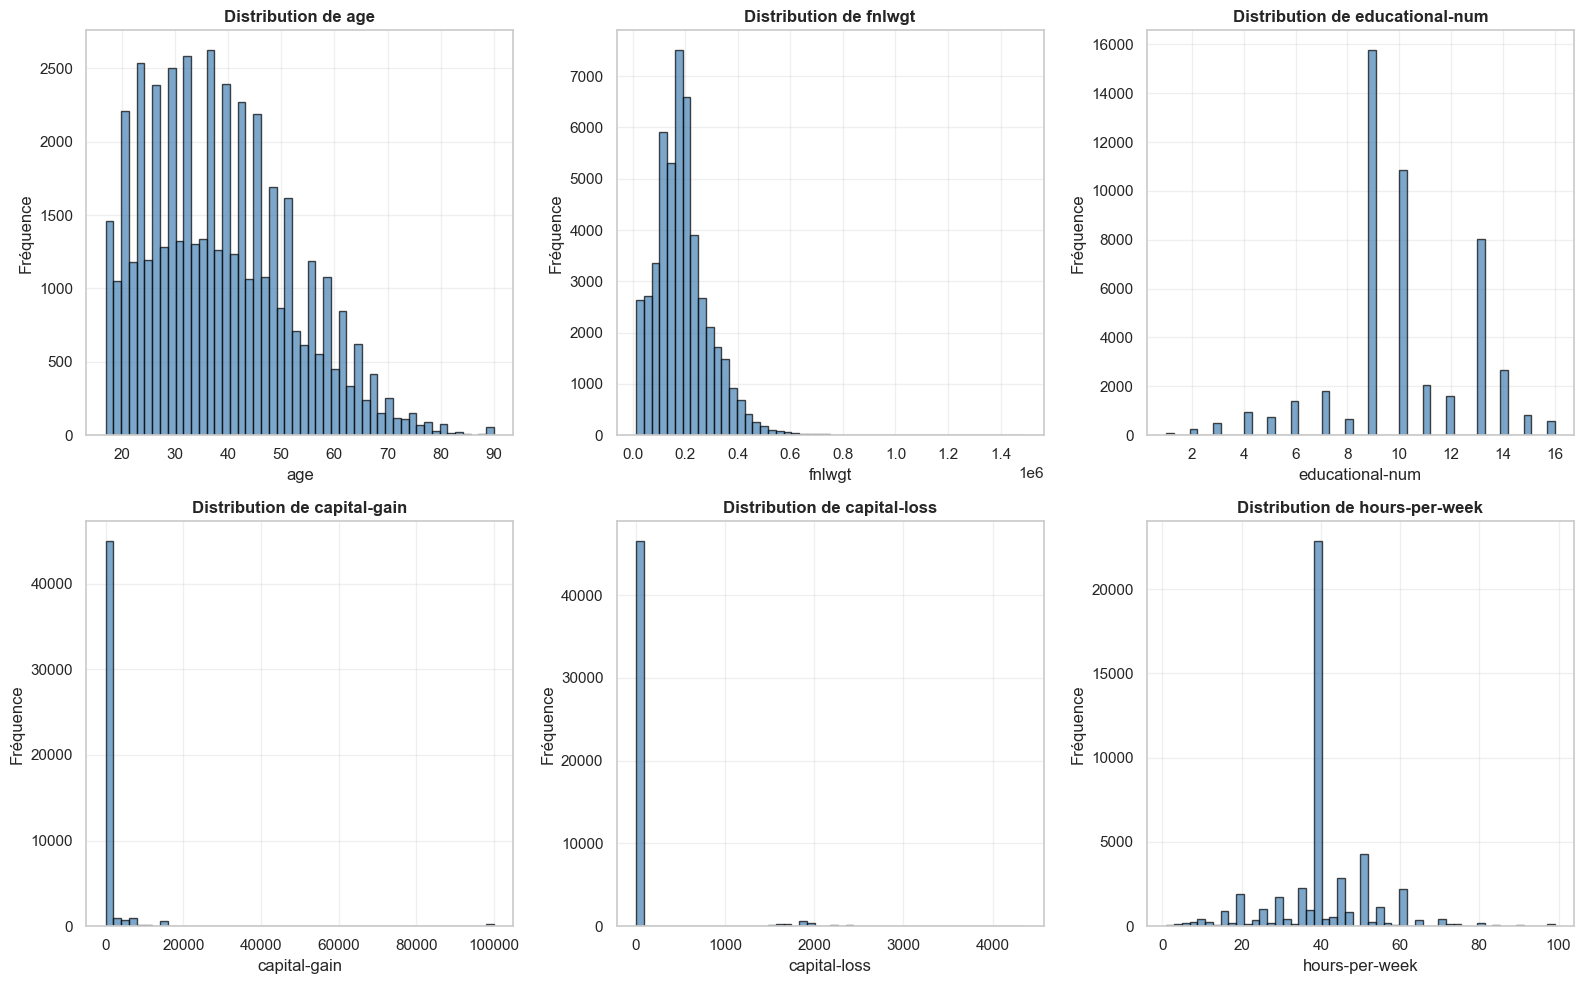

In [20]:
# Histogrammes des variables numériques
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    axes[idx].hist(df[col], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f"Distribution de {col}", fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("Fréquence")
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Interprétation** :

- **age** : Distribution relativement uniforme avec un pic autour de 30-40 ans (population active). Couvre l'ensemble des tranches d'âge actives (17-90 ans).

- **fnlwgt (final weight)** : Poids démographique calculé par le Census Bureau pour assurer la représentativité statistique. Chaque valeur indique combien de personnes dans la population américaine totale cette observation représente (ex: fnlwgt=200,000 signifie que cette personne "compte pour" 200,000 individus similaires). Distribution étalée avec un pic autour de 200k. **Note** : Cette variable est une pondération statistique externe et non une caractéristique intrinsèque de l'individu. Elle pourrait être **candidate à la suppression** lors du feature engineering, car elle n'apporte pas d'information prédictive directe sur le revenu personnel, mais sert uniquement à la représentativité des enquêtes.

- **educational-num** : Concentré autour de 9-10 (High School / Some College), reflétant le niveau d'éducation médian aux États-Unis. Forte concentration suggérant que la majorité de la population a un niveau secondaire ou post-secondaire partiel.

- **capital-gain** et **capital-loss** : Distributions fortement asymétriques avec une majorité écrasante de valeurs à 0 (pas de gains/pertes en capital). Les valeurs non-nulles sont rares mais élevées, correspondant à des investissements ou ventes immobilières/financières. Ces variables discriminent fortement les hauts revenus.

- **hours-per-week** : Pic très net autour de 40h (temps plein standard américain). Distribution quasi-normale centrée sur la semaine de travail typique, avec quelques valeurs extrêmes (temps partiel <20h, surmenage >60h).

### Distribution des variables catégorielles

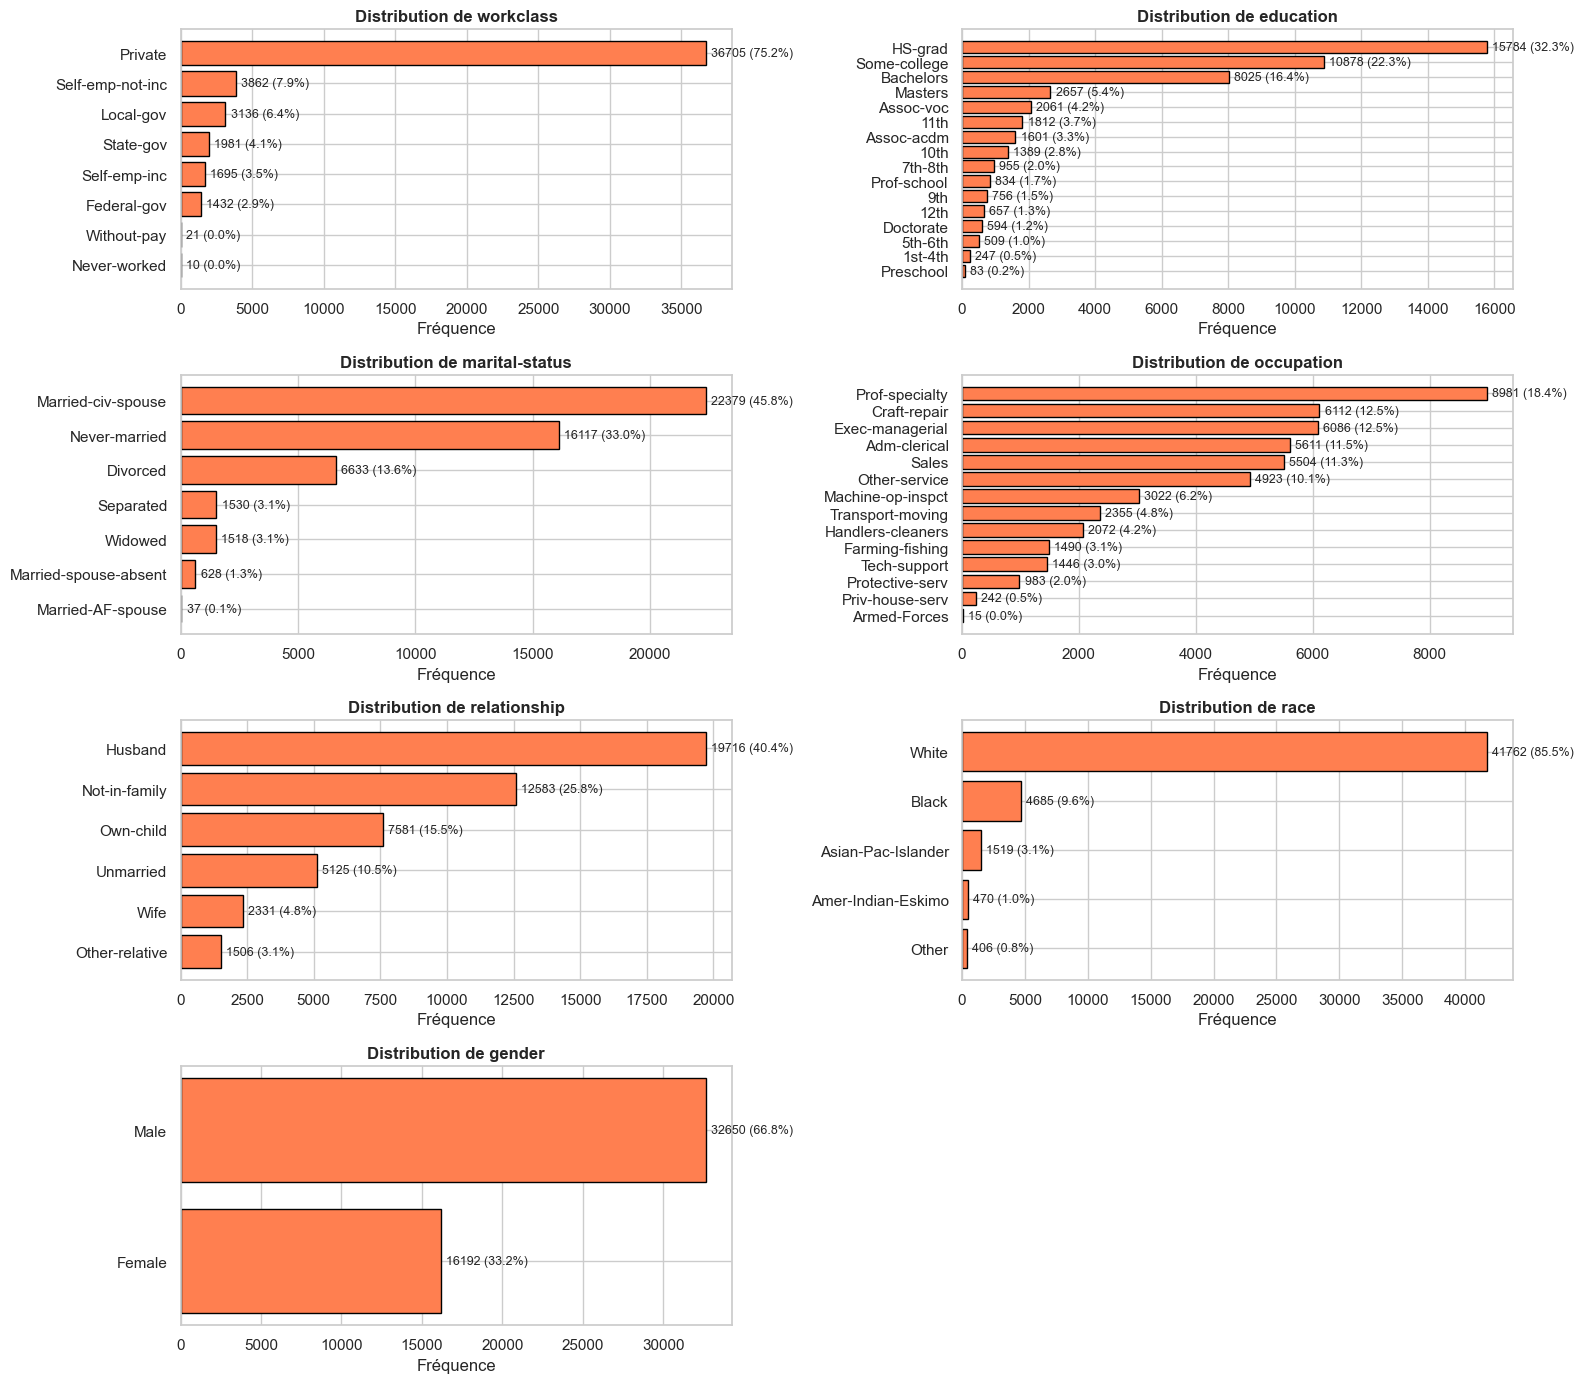

In [21]:
# Sélection des principales variables catégorielles à visualiser
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender']

fig, axes = plt.subplots(4, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    value_counts = df[col].value_counts()
    axes[idx].barh(value_counts.index, value_counts.values, color='coral', edgecolor='black')
    axes[idx].set_title(f"Distribution de {col}", fontsize=12, fontweight='bold')
    axes[idx].set_xlabel("Fréquence")
    axes[idx].invert_yaxis()
    
    # Afficher les pourcentages
    for i, v in enumerate(value_counts.values):
        axes[idx].text(v + max(value_counts.values)*0.01, i, f'{v} ({v/len(df)*100:.1f}%)', 
                       va='center', fontsize=9)

# Masquer le dernier subplot s'il est vide
if len(categorical_cols) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

**Interprétation** :

- **workclass** : Forte dominance du secteur **Private** (~75% des observations), reflétant la structure du marché du travail américain majoritairement privé. Les catégories Self-emp-not-inc (indépendants non incorporés) et Self-emp-inc (incorporés) représentent ensemble ~10%, indiquant une proportion notable d'entrepreneurs. Les secteurs publics (Local-gov, State-gov, Federal-gov) totalisent ~15%.

- **education** : Distribution hétérogène avec **HS-grad** (diplôme secondaire) et **Some-college** (études partielles) comme catégories dominantes. On observe une progression claire des niveaux d'éducation, avec une présence notable de Bachelors (~16%) et Masters (~5%), suggérant une population relativement éduquée dans l'échantillon. Les catégories inférieures (Preschool, 1st-4th) sont marginales.

- **marital-status** : Nette prédominance de **Married-civ-spouse** (~45%), suivie de **Never-married** (~35%). Les catégories de divorce/séparation totalisent ~15%. Cette variable est potentiellement **très prédictive** du revenu, car le statut marital est souvent corrélé aux doubles revenus dans un foyer.

- **occupation** : Distribution relativement équilibrée entre professions. **Prof-specialty** (professionnels spécialisés) et **Craft-repair** (artisans) sont les plus représentées. La diversité professionnelle reflète un échantillon représentatif de l'économie américaine, couvrant cols blancs (Exec-managerial, Prof-specialty) et cols bleus (Craft-repair, Machine-op-inspct).

- **relationship** : Variable hautement déséquilibrée avec **Husband** (~40%) et **Not-in-family** (~26%) dominants. Cette variable capture le rôle dans le foyer et est fortement corrélée avec le genre et le statut marital. **Attention** : Risque de **colinéarité** avec marital-status, pourrait nécessiter une feature selection.

- **race** : Très forte majorité **White** (~85%), suivie d'une représentation minoritaire de Black (~10%) et Asian-Pac-Islander (~3%). Cette distribution reflète la composition démographique historique des États-Unis (données Census 1994). **Note éthique** : Cette variable peut introduire des biais algorithmiques ; son utilisation doit être justifiée et surveillée pour éviter des prédictions discriminatoires.

- **gender** : Déséquilibre marqué avec **Male** (~67%) vs **Female** (~33%), ratio de 2:1. Ce déséquilibre reflète les différences historiques de participation au marché du travail (années 1990). **Attention** : Variable sensible pouvant introduire des biais de genre dans les prédictions ; son impact devra être analysé lors de l'interprétabilité du modèle final.

### Distribution de la variable cible (Target)

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="income")
plt.title("Répartition de la variable cible (income)")
plt.show()

income_ratio = df["income"].value_counts(normalize=True)
print("Répartition proportionnelle:\n", income_ratio)


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(data=df, x="income", y="age", ax=axes[0])
axes[0].set_title("Distribution de l'âge selon le revenu")

education_order = df["education"].value_counts().index
sns.countplot(data=df, y="education", hue="income", order=education_order, ax=axes[1])
axes[1].set_title("Répartition de l'income par niveau d'éducation")
plt.tight_layout()
plt.show()


In [ ]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Heatmap des corrélations (variables numériques)")
plt.show()


In [ ]:
scaler = StandardScaler()
pca = PCA(n_components=2, random_state=42)

numeric_data = df[numeric_cols].copy()
numeric_scaled = scaler.fit_transform(numeric_data)
pca_components = pca.fit_transform(numeric_scaled)

pca_df = pd.DataFrame(pca_components, columns=["PC1", "PC2"])
pca_df["income"] = df["income"].values

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="income", alpha=0.5)
plt.title("PCA (2 composantes) colorée par income")
plt.show()

explained_var = pca.explained_variance_ratio_
print(f"Variance expliquée par PC1+PC2: {explained_var.sum():.2%}")


In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(numeric_scaled)

cluster_df = pd.DataFrame(pca_components, columns=["PC1", "PC2"])
cluster_df["cluster"] = clusters.astype(str)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=cluster_df, x="PC1", y="PC2", hue="cluster", palette="tab10", alpha=0.6)
plt.title("Clusters K-Means projetés sur les composantes PCA")
plt.show()

cluster_target = pd.crosstab(clusters, df["income"], normalize="index")
print("Distribution de income par cluster:")
print(cluster_target)


# Préparation des données & Découpage Train/Test

Nous encodons la cible, séparons features/cible, puis construisons un pipeline de prétraitement combinant imputations, standardisation des numériques et encodage one-hot des variables catégorielles.


In [ ]:
target_col = "income"
label_encoder = LabelEncoder()
df["income_encoded"] = label_encoder.fit_transform(df[target_col])

y = df["income_encoded"]
X = df.drop(columns=[target_col, "income_encoded"])


In [ ]:
numeric_features = [
    "age",
    "fnlwgt",
    "educational-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]

categorical_features = [col for col in X.columns if col not in numeric_features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

print(f"Variables numériques ({len(numeric_features)}): {numeric_features}")
print(f"Variables catégorielles ({len(categorical_features)}): {categorical_features}")


## Partie 3 · Modélisation : Baseline vs Ensembles

Nous entraînons trois modèles (Logistic Regression, Random Forest, Gradient Boosting) encapsulés dans un pipeline complet, évaluons leurs performances via des rapports de classification, comparons Accuracy/F1, puis inspectons la matrice de confusion du meilleur modèle.


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

trained_pipelines = {}
metrics_records = []

for name, estimator in models.items():
    clf = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", estimator),
    ])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    metrics_records.append({"Model": name, "Accuracy": acc, "F1-Score": f1})
    trained_pipelines[name] = clf

    print(f"===== {name} =====")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

metrics_df = pd.DataFrame(metrics_records).sort_values(by="F1-Score", ascending=False)
metrics_df


In [ ]:
best_model_name = metrics_df.iloc[0]["Model"]
best_pipeline = trained_pipelines[best_model_name]
y_pred_best = best_pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Prédictions")
plt.ylabel("Vérité terrain")
plt.title(f"Matrice de confusion · {best_model_name}")
plt.show()

print(f"Meilleur modèle selon F1: {best_model_name}")


### Conclusion

Les modèles d'ensemble (Random Forest et Gradient Boosting) surpassent la régression logistique sur l'Accuracy et le F1-Score, le meilleur selon F1 étant affiché dans la matrice de confusion. Cette configuration offre une base solide pour de futures itérations (optimisation d'hyperparamètres, gestion du déséquilibre, interprétabilité).
